In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn import svm
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from lightgbm import LGBMClassifier
import sklearn.ensemble as ske
import seaborn as sns
%matplotlib inline

In [2]:
# Removes a warning in sklearn that will be fixed during an update mid 2018
import warnings

if __name__ == '__main__':
    warnings.filterwarnings(action='ignore', category=DeprecationWarning)
    le = preprocessing.LabelEncoder()
    le.fit([1, 2, 2, 6])
    le.transform([1, 1, 2, 6])
    le.inverse_transform([0, 0, 1, 2])

In [12]:
application_train = pd.read_csv('./data/application_train.csv', sep=',', header=0)
application_test = pd.read_csv('./data/application_test.csv', sep=',', header=0)

print('Training set shape: ' + str(train.shape))
print('Test set shape: ' + str(test.shape))

Training set shape: (307511, 122)
Test set shape: (48744, 121)


In [13]:
POS_CASH = pd.read_csv('./data/POS_CASH_balance.csv')
credit_card = pd.read_csv('./data/credit_card_balance.csv')
bureau = pd.read_csv('./data/bureau.csv')
previous_app = pd.read_csv('./data/previous_application.csv')

print('POS_CASH set shape: ' + str(POS_CASH.shape))
print('credit_card set shape: ' + str(credit_card.shape))
print('bureau set shape: ' + str(bureau.shape))
print('previous_app set shape: ' + str(previous_app.shape))

POS_CASH set shape: (10001358, 8)
credit_card set shape: (3840312, 23)
bureau set shape: (1716428, 17)
previous_app set shape: (1670214, 37)


In [35]:
def read_and_merge_data():

    print('Reading train/test...')
    application_train = pd.read_csv('./data/application_train.csv', sep=',', header=0)
    application_test = pd.read_csv('./data/application_test.csv', sep=',', header=0)
    
    print('Training set shape: ' + str(application_train.shape))
    print('Test set shape: ' + str(application_test.shape))
    print()
    
    print('Reading external data...')
    POS_CASH = pd.read_csv('./data/POS_CASH_balance.csv', sep=',', header=0)
    credit_card = pd.read_csv('./data/credit_card_balance.csv', sep=',', header=0)
    bureau = pd.read_csv('./data/bureau.csv', sep=',', header=0)
    previous_app = pd.read_csv('./data/previous_application.csv', sep=',', header=0)
    
    print('POS_CASH set shape: ' + str(POS_CASH.shape))
    print('credit_card set shape: ' + str(credit_card.shape))
    print('bureau set shape: ' + str(bureau.shape))
    print('previous_app set shape: ' + str(previous_app.shape))
    print()

    print("Converting...")
    le = preprocessing.LabelEncoder()
    POS_CASH['NAME_CONTRACT_STATUS'] = le.fit_transform(POS_CASH['NAME_CONTRACT_STATUS'].astype(str))
    nunique_status = POS_CASH[['SK_ID_CURR', 'NAME_CONTRACT_STATUS']].groupby('SK_ID_CURR').nunique()
    POS_CASH['NUNIQUE_STATUS'] = nunique_status['NAME_CONTRACT_STATUS']
    POS_CASH.drop(['SK_ID_PREV', 'NAME_CONTRACT_STATUS'], axis=1, inplace=True)

    credit_card['NAME_CONTRACT_STATUS'] = le.fit_transform(credit_card['NAME_CONTRACT_STATUS'].astype(str))
    nunique_status = credit_card[['SK_ID_CURR', 'NAME_CONTRACT_STATUS']].groupby('SK_ID_CURR').nunique()
    credit_card['NUNIQUE_STATUS'] = nunique_status['NAME_CONTRACT_STATUS']
    credit_card.drop(['SK_ID_PREV', 'NAME_CONTRACT_STATUS'], axis=1, inplace=True)

    bureau_cat_features = [f for f in bureau.columns if bureau[f].dtype == 'object']
    for f in bureau_cat_features:
        bureau[f] = le.fit_transform(bureau[f].astype(str))
        nunique = bureau[['SK_ID_CURR', f]].groupby('SK_ID_CURR').nunique()
        bureau['NUNIQUE_' + f] = nunique[f]
        bureau.drop([f], axis=1, inplace=True)
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace=True)

    previous_app_cat_features = [f for f in previous_app.columns if previous_app[f].dtype == 'object']
    for f in previous_app_cat_features:
        previous_app[f] = le.fit_transform(previous_app[f].astype(str))
        nunique = previous_app[['SK_ID_CURR', f]].groupby('SK_ID_CURR').nunique()
        previous_app['NUNIQUE_' + f] = nunique[f]
        previous_app.drop([f], axis=1, inplace=True)
    previous_app.drop(['SK_ID_PREV'], axis=1, inplace=True)
    print('Finished converting')
    print()

    print("Merging...")
    train = application_train.merge(POS_CASH.groupby('SK_ID_CURR').mean().reset_index(),
                                                                 how='left', on='SK_ID_CURR')
    test = application_test.merge(POS_CASH.groupby('SK_ID_CURR').mean().reset_index(),
                                                               how='left', on='SK_ID_CURR')

    train = train.merge(credit_card.groupby('SK_ID_CURR').mean().reset_index(),
                                                             how='left', on='SK_ID_CURR')
    test = test.merge(credit_card.groupby('SK_ID_CURR').mean().reset_index(),
                                                           how='left', on='SK_ID_CURR')

    train = train.merge(bureau.groupby('SK_ID_CURR').mean().reset_index(),
                                                        how='left', on='SK_ID_CURR')
    test = test.merge(bureau.groupby('SK_ID_CURR').mean().reset_index(),
                                                      how='left', on='SK_ID_CURR')

    train = train.merge(previous_app.groupby('SK_ID_CURR').mean().reset_index(),
                                                              how='left', on='SK_ID_CURR')
    test = test.merge(previous_app.groupby('SK_ID_CURR').mean().reset_index(),
                                                            how='left', on='SK_ID_CURR')
    print('Finished merging')
    print()

    print('Training set shape: ' + str(train.shape))
    print('Test set shape: ' + str(test.shape))
    print()
    
    return train, test

In [16]:
m_train = train.shape[0]
m_test = test.shape[0]

all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['TARGET'], axis=1, inplace=True)

print("all_data size is : {}".format(all_data.shape))

all_data size is : (356255, 198)


In [19]:
def plot_missing_ratio(df):
    missing = (all_data.isnull().sum() / len(all_data)) * 100
    missing = missing.drop(missing[missing == 0].index).sort_values(ascending=False)

    missing_ratio = pd.DataFrame({'Missing Ratio' :missing})

    f, ax = plt.subplots(figsize=(15, 12))
    plt.xticks(rotation='90')
    sns.barplot(x=missing.index, y=missing)
    plt.xlabel('Features', fontsize=10)
    plt.ylabel('Percent of missing values', fontsize=10)
    plt.title('Percent missing data by feature', fontsize=10)

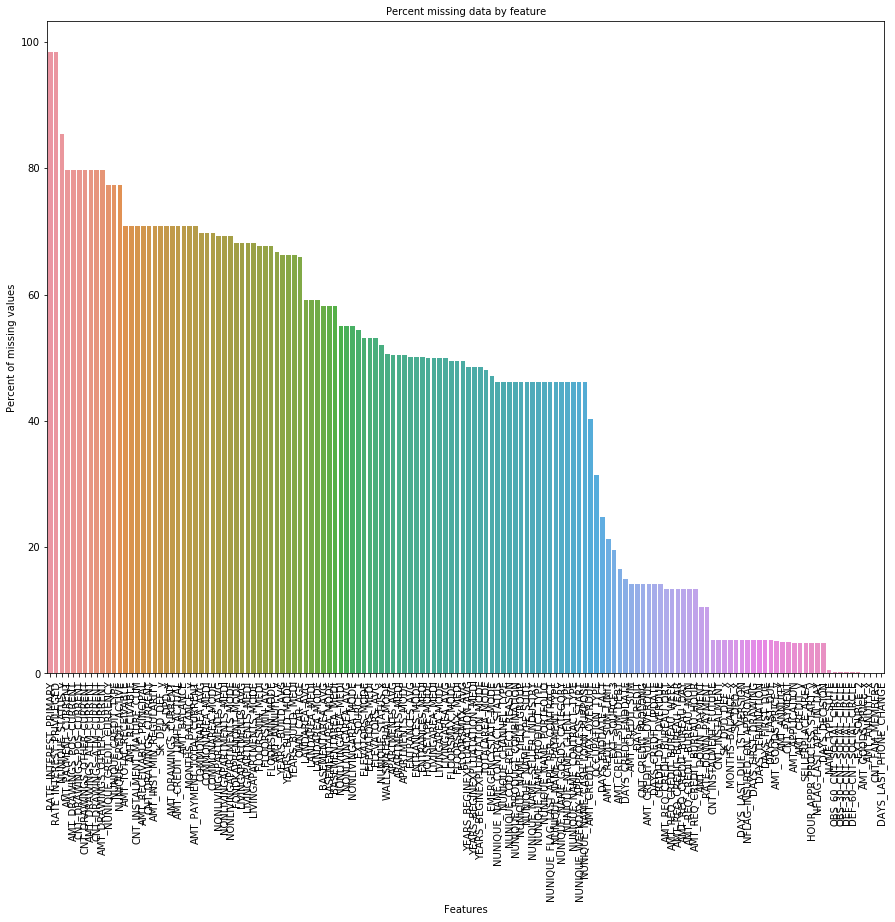

In [21]:
plot_missing_ratio(all_data)

In [22]:
categorical_columns = ['NAME_CONTRACT_TYPE',
                       'CODE_GENDER',
                       'FLAG_OWN_CAR',
                       'FLAG_OWN_REALTY',
                       'NAME_TYPE_SUITE',
                       'NAME_INCOME_TYPE',
                       'NAME_EDUCATION_TYPE',
                       'NAME_FAMILY_STATUS',
                       'NAME_HOUSING_TYPE',
                       'OCCUPATION_TYPE',
                       'WEEKDAY_APPR_PROCESS_START',
                       'ORGANIZATION_TYPE',
                       'FONDKAPREMONT_MODE',
                       'HOUSETYPE_MODE',
                       'WALLSMATERIAL_MODE',
                       'EMERGENCYSTATE_MODE']

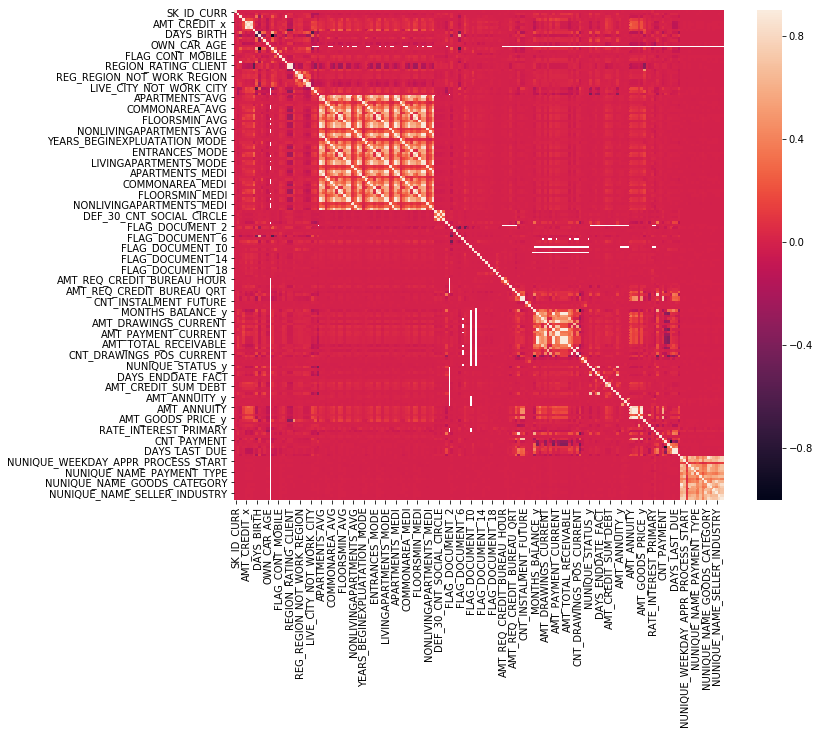

In [23]:
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

In [24]:
def replace_few_missing_with_default(df, max_ratio=5):

    missing = (df.isnull().sum() / len(df)) * 100
    missing = missing.drop(missing[missing == 0].index)
    few_missing = missing.drop(missing[missing > max_ratio].index)

    few_missing_columns = few_missing.index

    for col in few_missing_columns:
        df[col].fillna(df[col].value_counts().index[0], inplace = True)

    return df

In [47]:
def replace_missing(df, categorical_columns):
    
    numeric_columns = list(df.select_dtypes(include=[np.number]).columns.values)
    
    df = replace_few_missing_with_default(df)
    df[categorical_columns] = df[categorical_columns].fillna("UNKNOWN") 
    
    """for col in categorical_columns:
        if col in numeric_columns:
            df[col] = df[col].fillna(-999) 
        else:
            df[col] = df[col].fillna("UNKNOWN") """
    
    # Replace numeric values with mean
    for col in numeric_columns:
        df[col].fillna((df[col].mean()), inplace = True)   
    
            
    return df

In [26]:
print("Number of columns with missing data: " + str(len(all_data.columns[all_data.isnull().any()].tolist())))
all_data = replace_missing(all_data, categorical_columns)
print("Number of columns with missing data: " + str(len(all_data.columns[all_data.isnull().any()].tolist())))

Number of columns with missing data: 144
Number of columns with missing data: 0


In [27]:
def process_categorical(df, categorical_columns):
    
    # Significance of categories for target, will later try more with this
    #for col in categorical_columns:
    #   df.groupby(col).mean()['TARGET'].sort_values(ascending=False)

    df[categorical_columns] = df[categorical_columns].apply(preprocessing.LabelEncoder().fit_transform)
    df[categorical_columns] = df[categorical_columns].astype(str)
    df = pd.get_dummies(df)
    
    return df

In [28]:
df_all = process_categorical(all_data, categorical_columns)
df_all.head(1)

,AMT_ANNUITY,AMT_ANNUITY_x,AMT_ANNUITY_y,AMT_APPLICATION,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_CREDIT_MAX_OVERDUE,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,...,WALLSMATERIAL_MODE_5,WALLSMATERIAL_MODE_6,WALLSMATERIAL_MODE_7,WEEKDAY_APPR_PROCESS_START_0,WEEKDAY_APPR_PROCESS_START_1,WEEKDAY_APPR_PROCESS_START_2,WEEKDAY_APPR_PROCESS_START_3,WEEKDAY_APPR_PROCESS_START_4,WEEKDAY_APPR_PROCESS_START_5,WEEKDAY_APPR_PROCESS_START_6
0,9251.775,24700.5,0.0,179055.0,69973.192455,207320.669739,1681.029,108131.945625,49156.2,7997.14125,...,1,0,0,0,0,0,0,0,0,1


In [29]:
def rescale_data(df, mode='norm'):
    scalable_columns = list(df.select_dtypes(include=[np.float]))
    
    if mode=='norm':
        df[scalable_columns] = (df[scalable_columns] - np.min(df[scalable_columns])) \
                                / (np.max(df[scalable_columns]) - np.min(df[scalable_columns]))
    elif mode=='stand':
        df[scalable_columns] = (df[scalable_columns] - np.mean(df[scalable_columns])) \
                                / np.std(df[scalable_columns])
    return df

In [30]:
df_all = rescale_data(df_all)
print(df_all.select_dtypes(include=[np.float]).max())
df_all.select_dtypes(include=[np.float]).head(1)

AMT_ANNUITY                           1.0
AMT_ANNUITY_x                         1.0
AMT_ANNUITY_y                         1.0
AMT_APPLICATION                       1.0
AMT_BALANCE                           1.0
AMT_CREDIT_LIMIT_ACTUAL               1.0
AMT_CREDIT_MAX_OVERDUE                1.0
AMT_CREDIT_SUM                        1.0
AMT_CREDIT_SUM_DEBT                   1.0
AMT_CREDIT_SUM_LIMIT                  1.0
AMT_CREDIT_SUM_OVERDUE                1.0
AMT_CREDIT_x                          1.0
AMT_CREDIT_y                          1.0
AMT_DOWN_PAYMENT                      1.0
AMT_DRAWINGS_ATM_CURRENT              1.0
AMT_DRAWINGS_CURRENT                  1.0
AMT_DRAWINGS_OTHER_CURRENT            1.0
AMT_DRAWINGS_POS_CURRENT              1.0
AMT_GOODS_PRICE_x                     1.0
AMT_GOODS_PRICE_y                     1.0
AMT_INCOME_TOTAL                      1.0
AMT_INST_MIN_REGULARITY               1.0
AMT_PAYMENT_CURRENT                   1.0
AMT_PAYMENT_TOTAL_CURRENT         

,AMT_ANNUITY,AMT_ANNUITY_x,AMT_ANNUITY_y,AMT_APPLICATION,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_CREDIT_MAX_OVERDUE,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,...,SK_DPD_DEF_y,SK_DPD_x,SK_DPD_y,TOTALAREA_MODE,YEARS_BEGINEXPLUATATION_AVG,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_AVG,YEARS_BUILD_MEDI,YEARS_BUILD_MODE
0,0.030796,0.090032,0.0,0.044211,0.078255,0.153571,0.000014,0.000546,0.02144,0.02303,...,0.000093,0.0,0.002511,0.0149,0.9722,0.9722,0.9722,0.6192,0.6243,0.6341


In [48]:
def preprocess_data(df, categorical_columns):
    
    df = replace_missing(df, categorical_columns)
    df = process_categorical(df, categorical_columns)
    df = rescale_data(df)
    df = df.drop('SK_ID_CURR', axis=1)
    
    return df

In [36]:
train, test = read_and_merge_data()

m_train = train.shape[0]
m_test = test.shape[0]

y = train['TARGET']
train.drop(['TARGET'], axis=1, inplace=True)

ids = test['SK_ID_CURR']

all_data = pd.concat((train, test)).reset_index(drop=True)
all_data = preprocess_data(all_data, categorical_columns)

train = all_data.loc[0:m_train-1]
test = all_data.loc[m_train:]

train['TARGET'] = y

print('Training set shape: ' + str(train.shape))
print('Test set shape: ' + str(test.shape))

print("Number of columns with missing data: " + str(len(all_data.columns[all_data.isnull().any()].tolist())))

all_data.head(1)

Reading train/test...
Training set shape: (307511, 122)
Test set shape: (48744, 121)

Reading external data...
POS_CASH set shape: (10001358, 8)
credit_card set shape: (3840312, 23)
bureau set shape: (1716428, 17)
previous_app set shape: (1670214, 37)

Converting...
Finished converting

Merging...
Finished merging

Training set shape: (307511, 199)
Test set shape: (48744, 198)

Training set shape: (307511, 199)
Test set shape: (48744, 198)


C:\Users\Administrator\AppData\Local\conda\conda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Training set shape: (307511, 327)
Test set shape: (48744, 326)
Number of columns with missing data: 0


NameError: name 'df' is not defined

In [37]:
def split_data(df):
    
    df_train = df.sample(frac = 0.9, random_state = 42)
    df_val = df.drop(df_train.index)  
    
    X_train = df_train.drop(['TARGET'], axis=1).values
    y_train = df_train['TARGET'].values
    
    X_val = df_val.drop(['TARGET'], axis=1).values
    y_val = df_val['TARGET'].values
    
    return X_train, y_train, X_val, y_val

In [38]:
X_train, y_train, X_val, y_val = split_data(train)

In [ ]:
def train_clf(clf, X_train, y_train, X_val, y_val):
    
    clf.fit (X_train, y_train)
    
    y_act, y_pred = y_val, clf.predict_proba(X_val)
    scores = cross_val_score(clf, X_val, y_val, cv=10, scoring='accuracy')
    print("Validation Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))
    
    return clf

In [ ]:
rf_clf = ske.RandomForestClassifier(n_estimators=50)
rf_clf = train_clf(rf_clf, X_train, y_train, X_val, y_val)

In [39]:
def train_lgbm_clf(clf, X_train, y_train, X_val, y_val):
    
    clf.fit(X_train, y_train, 
            eval_set= [(X_val, y_val)],
            eval_metric='auc', 
            verbose=250, 
            early_stopping_rounds=150
           )
    
    y_act, y_pred = y_val, clf.predict(X_val)
    scores = cross_val_score(clf, X_val, y_val, cv=10, scoring='accuracy')
    print("Validation Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))
    print()
    print(classification_report(y_act, y_pred))
    
    return clf

In [40]:
lgbm_clf = LGBMClassifier(n_estimators=20000,
                          learning_rate=0.005,
                          num_leaves=70,
                          colsample_bytree=.8,
                          subsample=.9,
                          max_depth=7,
                          reg_alpha=.1,
                          reg_lambda=.1,
                          min_split_gain=.01,
                          min_child_weight=2)

lgbm_clf = train_lgbm_clf(lgbm_clf, X_train, y_train, X_val, y_val)

Training until validation scores don't improve for 150 rounds.
[250]	valid_0's auc: 0.74145
[500]	valid_0's auc: 0.748462
[750]	valid_0's auc: 0.756559
[1000]	valid_0's auc: 0.764215
[1250]	valid_0's auc: 0.768632
[1500]	valid_0's auc: 0.771687
[1750]	valid_0's auc: 0.773829
[2000]	valid_0's auc: 0.775232
[2250]	valid_0's auc: 0.776339
[2500]	valid_0's auc: 0.777415
[2750]	valid_0's auc: 0.778047
[3000]	valid_0's auc: 0.778599
[3250]	valid_0's auc: 0.779152
[3500]	valid_0's auc: 0.779479
[3750]	valid_0's auc: 0.779829
[4000]	valid_0's auc: 0.78011
[4250]	valid_0's auc: 0.780291
[4500]	valid_0's auc: 0.780494
[4750]	valid_0's auc: 0.780753
[5000]	valid_0's auc: 0.780892
[5250]	valid_0's auc: 0.781095
[5500]	valid_0's auc: 0.781224
[5750]	valid_0's auc: 0.781411
[6000]	valid_0's auc: 0.781441
Early stopping, best iteration is:
[5949]	valid_0's auc: 0.781477
Validation Accuracy: 0.92 (+/- 0.00)

             precision    recall  f1-score   support

          0       0.92      1.00      0.

In [41]:
def predict(df, ids, clf, export_path):
    
    # Make predictions
    X = df.values
    y = clf.predict_proba(X, num_iteration=clf.best_iteration_)[:, 1]
    
    # Combine ids and predictions
    y = np.column_stack((ids, y))
    
    # Restore pandas df
    pred = pd.DataFrame(y)
    pred.columns = ["SK_ID_CURR", "TARGET"]
    
    pred["SK_ID_CURR"] = pred["SK_ID_CURR"].astype('int64')
    
    # Export
    pred.to_csv(export_path, sep=',', index=False)
    
    return pred

In [43]:
#df_test = pd.read_csv('./data/application_test.csv', sep=',', header=0)
#df_pred = predict(df_test, rf_clf, categorical_columns, './predictions/rf_pred.csv')
pred = predict(test, ids, lgbm_clf, './predictions/lgbm_pred.csv')

In [76]:
print(pred.sum())

SK_ID_CURR    1.354092e+10
TARGET        3.845379e+03
dtype: float64


In [45]:
print(pred.sum())

SK_ID_CURR    1.354092e+10
TARGET        3.585847e+03
dtype: float64


In [77]:
pred.head(3)

,SK_ID_CURR,TARGET
0,100001,0.026558
1,100005,0.107355
2,100013,0.025906


In [46]:
pred.head(3)

,SK_ID_CURR,TARGET
0,100001,0.041259
1,100005,0.116808
2,100013,0.037179
